In [380]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GINConv
from torch_geometric.datasets import Planetoid, WikiCS
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx
import random
from torch_sparse import SparseTensor
import networkx as nx

In [381]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [228]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        i = 0
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            i += 1
        x = self.convs[-1](x, adj_t)
        return x

In [231]:
model = SAGE(1,5,5,3,0).to(device)
torch.manual_seed(99)
model.reset_parameters()

In [232]:
n=2
sizes = [45*n, 10*n, 45*n]
probs = [[0.55, 0.05, 0.02], [0.05, 0.55, 0.05], [0.02, 0.05, 0.55]]
g = nx.stochastic_block_model(sizes, probs, seed=1)
data = from_networkx(g)
num_nodes = g.number_of_nodes()
data.x = torch.zeros(num_nodes, 1)
for i in range(num_nodes):
    data.x[i] = g.degree[i]/num_nodes
data.x = data.x.to(device)
adj = SparseTensor(row=data.edge_index[0], col=data.edge_index[1],sparse_sizes=(num_nodes, num_nodes))
adj_t = adj.t().to(device)
out_1 = model(data.x, adj_t)

In [233]:
n=20
sizes = [45*n, 10*n, 45*n]
#probs = [[0.55, 0.005, 0.002], [0.005, 0.55, 0.005], [0.002, 0.005, 0.55]]
probs = [[0.55, 0.05, 0.02], [0.05, 0.55, 0.05], [0.02, 0.05, 0.55]]
g = nx.stochastic_block_model(sizes, probs, seed=0)
data = from_networkx(g)
num_nodes = g.number_of_nodes()
data.x = torch.zeros(num_nodes, 1)
for i in range(num_nodes):
    data.x[i] = g.degree[i]/num_nodes
data.x = data.x.to(device)
#data.x[:(45*n)] = 0.5*0.45+0.05*0.1+0.45*0.02
#data.x[(55*n):] = 0.5*0.45+0.05*0.1+0.45*0.02
#data.x[(45*n):(55*n)] = 0.05*0.45*2+0.65*0.1
adj = SparseTensor(row=data.edge_index[0], col=data.edge_index[1],sparse_sizes=(num_nodes, num_nodes))
adj_t = adj.t().to(device)
out_2 = model(data.x, adj_t)

In [235]:
n=200
sizes = [45*n, 10*n, 45*n]
probs = [[0.55, 0.05, 0.02], [0.05, 0.55, 0.05], [0.02, 0.05, 0.55]]
g = nx.stochastic_block_model(sizes, probs, seed=0)
data = from_networkx(g)
num_nodes = g.number_of_nodes()
data.x = torch.zeros(num_nodes, 1)
for i in range(num_nodes):
    data.x[i] = g.degree[i]/num_nodes
#data.x[:(45*n)] = 0.5*0.45+0.05*0.1+0.45*0.02
#data.x[(55*n):] = 0.5*0.45+0.05*0.1+0.45*0.02
#data.x[(45*n):(55*n)] = 0.05*0.45*2+0.65*0.1
data.x = data.x.to(device)
adj = SparseTensor(row=data.edge_index[0], col=data.edge_index[1],sparse_sizes=(num_nodes, num_nodes))
adj_t = adj.t().to(device)
out_3 = model(data.x, adj_t)

In [237]:
i = 0
j = 0
x = torch.tensor([0.2615,0.1]).to(device) # is the d_W for different blocks in the given SBM
x = x.reshape(1,-1)
#x = data.x
for param in model.parameters():
    if i==0:
        nei = x
        nei_1 = (nei[:,0]*0.2565+nei[:,1]*0.005).reshape(-1,1)/0.2615
        nei_2 = (nei[:,0]*0.045+nei[:,1]*0.055).reshape(-1,1)/0.1
        nei = torch.cat((nei_1,nei_2),dim=1)
        nei = torch.matmul(param,nei)
        x_new = nei
        i += 1
    elif i==1:
        b = param.reshape(-1,1)
        x_new = x_new+b
        i += 1
    elif i==2:
        x = x_new+torch.matmul(param,x)
        j += 1
        if not j==3:
            x = F.relu(x)
            #x = x
        i = 0
out_c = x.t()

In [242]:
n = 2
out_c1 = torch.cat((out_c[0].repeat(45*n,1), out_c[1].repeat(10*n,1), out_c[0].repeat(45*n,1)),dim=0)
diff = out_1-out_c1
val, ind = torch.max(torch.abs(out_1-out_c1),dim=1)
diff_1 = torch.ones(100*n)
for i in range(100*n):
    diff_1[i] = diff[i][ind[i]]
#print(torch.max(val))

In [243]:
n = 20
out_c2 = torch.cat((out_c[0].repeat(45*n,1), out_c[1].repeat(10*n,1), out_c[0].repeat(45*n,1)),dim=0)
diff = out_2-out_c2
val, ind = torch.max(torch.abs(out_2-out_c2),dim=1)
diff_2 = torch.ones(100*n)
for i in range(100*n):
    diff_2[i] = diff[i][ind[i]]
#print(torch.max(val))

In [244]:
n = 200
out_c3 = torch.cat((out_c[0].repeat(45*n,1), out_c[1].repeat(10*n,1), out_c[0].repeat(45*n,1)),dim=0)
diff = out_3-out_c3
val, ind = torch.max(torch.abs(out_3-out_c3),dim=1)
diff_3 = torch.ones(100*n)
for i in range(100*n):
    diff_3[i] = diff[i][ind[i]]
#print(torch.max(val))

In [ ]:
import matplotlib 
plt.rcParams.update({'font.size': 14})
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
plt.plot(np.log10(nodes_nums),np.log10(l1error.detach().numpy()))
plt.xlabel(r'$log_{10}(N^{te})$')
plt.ylabel(r'$\log_{10}(\delta^{\bullet}_{A-W})$')
plt.title('(a)')
plt.legend(['slope: -0.470'])
plt.savefig('conv-gmpnn.pdf', format='pdf')

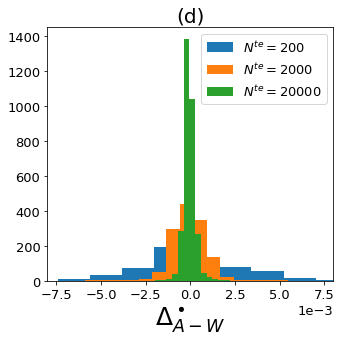

In [353]:
import matplotlib 
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=25) 
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13) 
plt.hist(diff_1.detach().numpy(),density=True,bins=15)
plt.hist(diff_2.detach().numpy(),density=True,bins=15)
plt.hist(diff_3.detach().numpy(),density=True,bins=15)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([-0.008,0.008])
plt.title('(d)')
plt.xlabel(r'$\Delta^\bullet_{A-W}$')
plt.legend([r'$N^{te}=200$',r'$N^{te}=2000$',r'$N^{te}=20000$'])
plt.tight_layout()
plt.savefig('conv.pdf', format='pdf')
plt.show() 

In [260]:
n = 2
diff_1iso = torch.zeros(45*45*n*n,1)
k = 0
for i in range(45*n):
    for j in range(55*n,100*n):
        val, ind = torch.max(torch.abs(out_1[i]-out_1[j]),dim=0)
        diff_1iso[k] = (out_1[i]-out_1[j])[ind]
        k += 1

In [261]:
n = 20
indice = random.sample(range(45*45*n*n), 100000)
indice = torch.tensor(indice)
id_b1 = indice.div(45*n, rounding_mode="floor")
id_b2 = torch.remainder(indice,45*n)
diff = out_2[id_b1]-out_2[id_b2+55*n]
diff_2iso = torch.ones(100000)
val, ind = torch.max(torch.abs(diff),dim=1)
for i in range(100000):
    diff_2iso[i] = diff[i][ind[i]]

In [262]:
n = 200
indice = random.sample(range(45*45*n*n), 100000)
indice = torch.tensor(indice)
id_b1 = indice.div(45*n, rounding_mode="floor")
id_b2 = torch.remainder(indice,45*n)
diff = out_3[id_b1]-out_3[id_b2+55*n]
diff_3iso = torch.ones(100000)
val, ind = torch.max(torch.abs(diff),dim=1)
for i in range(100000):
    diff_3iso[i] = diff[i][ind[i]]

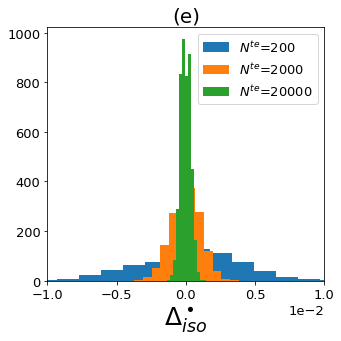

In [372]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=25) 
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13) 
plt.hist(diff_1iso.detach().numpy(),density=True,bins=14)
plt.hist(diff_2iso.detach().numpy(),density=True,bins=14)
plt.hist(diff_3iso.detach().numpy(),density=True,bins=14)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([-0.01,0.01])
plt.title('(e)')
plt.xlabel(r'$\Delta^\bullet_{iso}$')
plt.legend([r'$N^{te}$=200',r'$N^{te}$=2000',r'$N^{te}$=20000'])
plt.tight_layout()
plt.savefig('conv-iso.pdf', format='pdf')
plt.show() 

In [271]:
n = 2
diff_1no_iso = torch.zeros(45*10*n*n,1)
k = 0
for i in range(45*n):
    for j in range(45*n,55*n):
        val, ind = torch.max(torch.abs(out_1[i]-out_1[j]),dim=0)
        diff_1no_iso[k] = (out_1[i]-out_1[j])[ind]
        k += 1

In [272]:
n = 20
indice = random.sample(range(45*10*n*n), 100000)
indice = torch.tensor(indice)
id_b1 = indice.div(10*n, rounding_mode="floor")
id_b2 = torch.remainder(indice,10*n)
diff = out_2[id_b1]-out_2[id_b2+45*n]
diff_2no_iso = torch.ones(100000)
val, ind = torch.max(torch.abs(diff),dim=1)
for i in range(100000):
    diff_2no_iso[i] = diff[i][ind[i]]

In [273]:
n = 200
indice = random.sample(range(45*10*n*n), 100000)
indice = torch.tensor(indice)
id_b1 = indice.div(10*n, rounding_mode="floor")
id_b2 = torch.remainder(indice,10*n)
diff = out_3[id_b1]-out_3[id_b2+45*n]
diff_3no_iso = torch.ones(100000)
val, ind = torch.max(torch.abs(diff),dim=1)
for i in range(100000):
    diff_3no_iso[i] = diff[i][ind[i]]

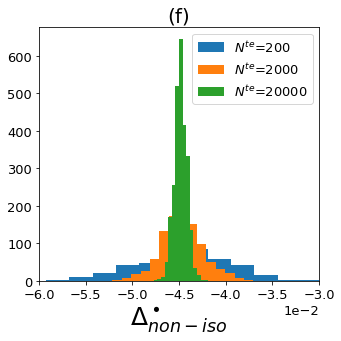

In [373]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=25) 
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13) 
plt.hist(diff_1no_iso.detach().numpy(),density=True,bins=15)
plt.hist(diff_2no_iso.detach().numpy(),density=True,bins=15)
plt.hist(diff_3no_iso.detach().numpy(),density=True,bins=15)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([-0.06,-0.03])
plt.title('(f)')
plt.xlabel(r'$\Delta^\bullet_{non-iso}$')
plt.legend([r'$N^{te}$=200',r'$N^{te}$=2000',r'$N^{te}$=20000'])
plt.tight_layout()
plt.savefig('conv-noniso.pdf', format='pdf')
plt.show() 

In [292]:
model = SAGE(1,5,5,3,0)#.to(device)
torch.manual_seed(99)
model.reset_parameters()

In [175]:
# untrained gMPNN
import numpy as np
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
l1error = torch.ones(9)
probs = [[0.55, 0.05, 0.02], [0.05, 0.55, 0.05], [0.02, 0.05, 0.55]]
idddddd = 0
model.eval()
for n in nodes_nums:
    sizes = [int(0.45*n), int(0.1*n), int(0.45*n)]
    g = nx.stochastic_block_model(sizes, probs, seed=36)
    data = from_networkx(g)
    #data.x = data.x.to(device)
    num_nodes = g.number_of_nodes()
    data.x = torch.zeros(num_nodes, 1)
    for i in range(num_nodes):
        data.x[i] = g.degree[i]/num_nodes
    #data.x[:(45*n)] = 0.5*0.45+0.05*0.1+0.45*0.02
    #data.x[(55*n):] = 0.5*0.45+0.05*0.1+0.45*0.02
    #data.x[(45*n):(55*n)] = 0.05*0.45*2+0.65*0.1
    adj = SparseTensor(row=data.edge_index[0], col=data.edge_index[1],sparse_sizes=(num_nodes, num_nodes))
    adj_t = adj.t()#.to(device)
    out_n = model(data.x, adj_t)
    out_cn = torch.cat((out_c[0].repeat(int(0.45*n),1), out_c[1].repeat(int(0.1*n),1), out_c[0].repeat(int(0.45*n),1)),dim=0)
    diff = out_n-out_cn
    l1error[idddddd] = torch.max(torch.abs(diff))
    print(torch.max(torch.abs(diff)))
    idddddd += 1

tensor(0.1054, grad_fn=<MaxBackward1>)
tensor(0.0456, grad_fn=<MaxBackward1>)
tensor(0.0377, grad_fn=<MaxBackward1>)
tensor(0.0226, grad_fn=<MaxBackward1>)
tensor(0.0189, grad_fn=<MaxBackward1>)
tensor(0.0147, grad_fn=<MaxBackward1>)
tensor(0.0111, grad_fn=<MaxBackward1>)
tensor(0.0084, grad_fn=<MaxBackward1>)
tensor(0.0058, grad_fn=<MaxBackward1>)


In [176]:
l1error

tensor([0.1054, 0.0456, 0.0377, 0.0226, 0.0189, 0.0147, 0.0111, 0.0084, 0.0058],
       grad_fn=<CopySlices>)

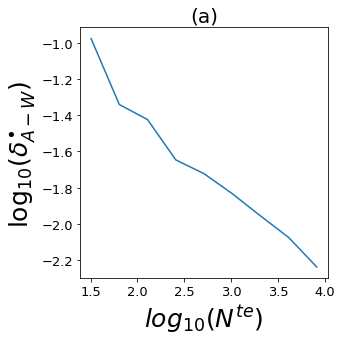

In [374]:
import matplotlib 
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=25) 
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
plt.plot(np.log10(nodes_nums),np.log10(l1error.detach().numpy()))
plt.xlabel(r'$log_{10}(N^{te})$')
plt.ylabel(r'$\log_{10}(\delta^{\bullet}_{A-W})$')
plt.title('(a)')
plt.tight_layout()
plt.savefig('conv-gmpnn.pdf', format='pdf')

In [202]:
# outputs for the cMPNN with fixed \Psi
n_1 = 9
n_2 = 2
n_3 = 9
w1 = torch.cat((torch.ones(int(n_1)) * 0.55, torch.ones(int(n_2)) * 0.05, torch.ones(int(n_3)) * 0.02))
w2 = torch.cat((torch.ones(int(n_1)) * 0.05, torch.ones(int(n_2)) * 0.55, torch.ones(int(n_3)) * 0.05))
w3 = torch.cat((torch.ones(int(n_1)) * 0.02, torch.ones(int(n_2)) * 0.05, torch.ones(int(n_3)) * 0.55))
W = torch.cat((w1.repeat(n_1, 1), w2.repeat(n_2, 1), w3.repeat(n_3, 1)), dim=0)#.to(device)
num_nodes = 20
f = torch.ones(num_nodes, num_nodes)
a = W
de_2 = torch.sparse.mm(a,a.t()) #distance
for i in range(3):
    agg = torch.sparse.mm(a,f.t())
    agg = agg+agg.t()
    agg = agg/(2*de_2)
    f = f/agg
print(f[0])

tensor([0.5494, 0.5494, 0.5494, 0.5494, 0.5494, 0.5494, 0.5494, 0.5494, 0.5494,
        0.0570, 0.0570, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228,
        0.0228, 0.0228])


In [204]:
# fixed 2-gMPNN
import numpy as np
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
l1error_joint_new = torch.ones(9)
probs = [[0.55, 0.05, 0.02], [0.05, 0.55, 0.05], [0.02, 0.05, 0.55]]
idddddd = 0
#model.eval()
for n in nodes_nums:
    n_1 = int(0.45*n)
    n_2 = int(0.1*n)
    n_3 = n_1
    sizes = [n_1,n_2,n_3]
    g = nx.stochastic_block_model(sizes, probs,seed=2)
    data = from_networkx(g)
    num_nodes = g.number_of_nodes()
    f = torch.ones(num_nodes, num_nodes).to(device)
    a = torch.sparse.FloatTensor(data.edge_index, torch.ones(data.edge_index.size(1)), torch.Size([num_nodes, num_nodes]))
    de_2 = torch.sparse.mm(a,a.t()) #distance
    de_2 = ((torch.ones(num_nodes, num_nodes)-de_2)>0)+de_2
    de_2 = de_2.to(device)
    a = a.to(device)
    for i in range(3):
        agg = torch.sparse.mm(a,f.t())
        agg = agg+agg.t()
        agg = agg/(2*de_2)
        f = f/agg
    f.fill_diagonal_(1.0)
    f = f.cpu()
    #Calculated 2-cMPNN result
    w1 = torch.cat((torch.ones(int(n_1))*0.5494,torch.ones(int(n_2))*0.0570,torch.ones(int(n_3))*0.0228))
    w2 = torch.cat((torch.ones(int(n_1))*0.0570,torch.ones(int(n_2))*0.5323,torch.ones(int(n_3))*0.0570))
    w3 = torch.cat((torch.ones(int(n_1))*0.0228,torch.ones(int(n_2))*0.0570,torch.ones(int(n_3))*0.5494))
    W = torch.cat((w1.repeat(n_1,1),w2.repeat(n_2,1),w3.repeat(n_3,1)),dim=0)
    W.fill_diagonal_(1.0)
    W = W
    diff = f-W
    l1error_joint_new[idddddd] = torch.max(torch.abs(diff))
    print(torch.max(torch.abs(diff)))
    idddddd += 1

tensor(8.9118)
tensor(6.6946)
tensor(5.4689)
tensor(2.5617)
tensor(1.0796)
tensor(0.8172)
tensor(0.5068)
tensor(0.3851)
tensor(0.3064)


In [205]:
l1error_joint_new

tensor([8.9118, 6.6946, 5.4689, 2.5617, 1.0796, 0.8172, 0.5068, 0.3851, 0.3064])

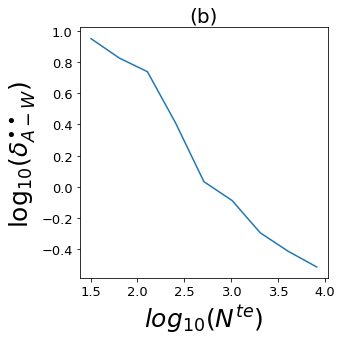

In [375]:
import matplotlib 
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=25) 
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
plt.plot(np.log10(nodes_nums),np.log10(l1error_joint_new.detach().numpy()))
plt.xlabel(r'$log_{10}(N^{te})$')
plt.ylabel(r'$\log_{10}(\delta^{\bullet \bullet}_{A-W})$')
plt.title('(b)')
plt.tight_layout()
plt.savefig('conv-2gmpnn.pdf', format='pdf')

In [210]:
class jgMPNN(torch.nn.Module):
    def __init__(self, in_channels=1, hidden_channels=5, out_channels=1):
        super(jgMPNN, self).__init__()
        self.hid = hidden_channels
        self.nn1 = torch.nn.Linear(in_channels+in_channels, hidden_channels)
        self.nn2 = torch.nn.Linear(2*hidden_channels, out_channels)

    def reset_parameters(self):
        self.nn1.reset_parameters()
        self.nn2.reset_parameters()

    def forward(self, a, num_nodes, f, de_2, use_w=False):
        agg = torch.sparse.mm(a.t(), f)
        agg = agg + agg.t()
        agg = agg / (2 * de_2)
        f = f.reshape(-1,1)
        agg = agg.reshape(-1, 1)
        if self.hid > 1:
            f = self.nn1(torch.cat((f, agg), dim=1)).reshape(num_nodes, num_nodes, self.hid)
            f = F.relu(f)
            if not use_w:
                a = a.to_dense()
            agg = torch.einsum('iz,jzk->ijk', a.t(), f)
            agg += torch.einsum('izk,jz->ijk', f, a)
            #de_2 = de_2.to_dense()
            agg = agg/(de_2.reshape(num_nodes, num_nodes, 1).repeat(1, 1, self.hid))
        else:
            f = self.nn1(torch.cat((f, agg), dim=1)).reshape(num_nodes, num_nodes)
            f = F.relu(f)
            agg = torch.sparse.mm(a.t(), f)
            agg = agg + agg.t()
            agg = agg / (2 * de_2)
        f = f.reshape(-1, self.hid)
        agg = agg.reshape(-1, self.hid)
        f = self.nn2(torch.cat((f,agg),dim=1)).reshape(num_nodes, num_nodes)
        f = torch.sigmoid(f)
        return f

In [221]:
device = 'cpu'
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = jgMPNN().to(device)
torch.manual_seed(99)
model.reset_parameters()
num_nodes = 20
n_1 = int(0.45*num_nodes)
n_2 = int(0.1*num_nodes)
n_3 = n_1
w1 = torch.cat((torch.ones(int(n_1))*0.55,torch.ones(int(n_2))*0.05,torch.ones(int(n_1))*0.02))
w2 = torch.cat((torch.ones(int(n_1))*0.05,torch.ones(int(n_2))*0.55,torch.ones(int(n_1))*0.05))
w3 = torch.cat((torch.ones(int(n_1))*0.02,torch.ones(int(n_2))*0.05,torch.ones(int(n_1))*0.55))
W = torch.cat((w1.repeat(int(n_1),1),w2.repeat(int(n_2),1),w3.repeat(int(n_1),1)),dim=0).to(device)
de_2 = torch.sparse.mm(W,W.t()).to(device)
#de_2 = torch.sparse.mm(W,W.t()) #distance
w = torch.ones(num_nodes,num_nodes).to(device)
W_new = model(W, num_nodes, w, de_2, use_w=True)
print(W_new[0])
print(W_new[10])

tensor([0.0145, 0.0145, 0.0145, 0.0145, 0.0145, 0.0145, 0.0145, 0.0145, 0.0145,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2510e-08, 1.2510e-08, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<SelectBackward0>)


In [224]:
import numpy as np
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
#nodes_nums = [2**9, 2**10]
#nodes_nums = [2**10, 2**11, 2**12, 2**13]
l1error_joint_learn = torch.ones(9)
probs = [[0.55, 0.05, 0.02], [0.05, 0.55, 0.05], [0.02, 0.05, 0.55]]
idddddd = 0
model = jgMPNN().to(device)
torch.manual_seed(99)
model.reset_parameters()
for n in nodes_nums:
    n_1 = int(0.45*n)
    n_2 = int(0.1*n)
    n_3 = n_1
    sizes = [n_1,n_2,n_3]
    g = nx.stochastic_block_model(sizes, probs,seed=2)
    data = from_networkx(g)
    num_nodes = g.number_of_nodes()
    f = torch.ones(num_nodes, num_nodes).to(device) 
    a = torch.sparse.FloatTensor(data.edge_index, torch.ones(data.edge_index.size(1)), torch.Size([num_nodes, num_nodes]))
    de_2 = torch.sparse.mm(a,a.t()) #distance
    de_2 = ((torch.ones(num_nodes, num_nodes)-de_2)>0)+de_2
    de_2 = de_2.to(device)
    a = a.to(device)
    f_new = model(a, num_nodes, f, de_2)
    f_new.fill_diagonal_(1.0)
    w1 = torch.cat((torch.ones(int(n_1))*0.0145,torch.ones(int(n_2))*0.0,torch.ones(int(n_1))*0.0))
    w2 = torch.cat((torch.ones(int(n_1))*0.0,torch.ones(int(n_2))*1.2510e-08,torch.ones(int(n_1))*0.0))
    w3 = torch.cat((torch.ones(int(n_1))*0.0,torch.ones(int(n_2))*0.0,torch.ones(int(n_1))*0.0145))
    W_new = torch.cat((w1.repeat(int(n_1),1),w2.repeat(int(n_2),1),w3.repeat(int(n_1),1)),dim=0)
    W_new.fill_diagonal_(1.0)
    l1error_joint_learn[idddddd] = torch.max(torch.abs(f_new-W_new))
    print(torch.max(torch.abs(f_new-W_new)))
    idddddd += 1

tensor(0.2850, grad_fn=<MaxBackward1>)
tensor(0.1341, grad_fn=<MaxBackward1>)
tensor(0.1658, grad_fn=<MaxBackward1>)
tensor(0.1040, grad_fn=<MaxBackward1>)
tensor(0.0870, grad_fn=<MaxBackward1>)
tensor(0.0383, grad_fn=<MaxBackward1>)
tensor(0.0263, grad_fn=<MaxBackward1>)
tensor(0.0170, grad_fn=<MaxBackward1>)
tensor(0.0116, grad_fn=<MaxBackward1>)


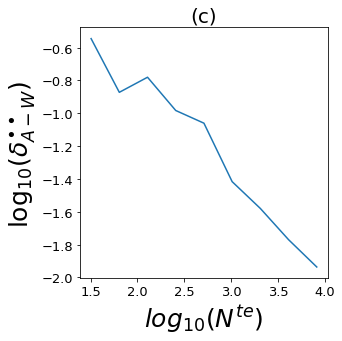

In [377]:
import matplotlib 
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=25) 
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 
nodes_nums = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
plt.plot(np.log10(nodes_nums),np.log10(l1error_joint_learn.detach().numpy()))
plt.xlabel(r'$log_{10}(N^{te})$')
plt.ylabel(r'$\log_{10}(\delta^{\bullet \bullet}_{A-W})$')
plt.title('(c)')
plt.tight_layout()
plt.savefig('conv-2gmpnn-nn.pdf', format='pdf')